In [56]:
#Importing necessary libraries
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
import os
import librosa.display
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

In [57]:
import pandas as pd

# Load the CSV file
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
df = pd.read_csv(metadata_path)

# Display the first few rows of the dataframe 
df.head()


,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [58]:
#distribution of species
species_dist = df['species'].value_counts()
print(species_dist)

species
melodia        1256
polyglottos    1182
cardinalis     1074
migratorius    1017
bewickii        893
Name: count, dtype: int64


In [59]:
# Checking for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

id               0
genus            0
species          0
subspecies    3876
name             0
recordist        0
country          0
location         0
latitude        90
longitude       90
altitude        42
sound_type       0
source_url       0
license          0
time             0
date             0
remarks       1859
filename         0
dtype: int64


The primary input for generating spectrograms is the audio file itself. Missing values in metadata (like subspecies, latitude, longitude, altitude, and remarks) won't affect the generation of spectrograms, as long as the audio files (filename) are intact and not missing. 

In [60]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB
None


**Feature Extraction**

In [61]:

def load_bird_sounds_from_csv(metadata_path, audio_files_path):
    df = pd.read_csv(metadata_path)
    bird_sounds = []
    labels = []
    sr = None  # Sampling rate of the audio file will be set based on the first loaded file

    for index, row in df.iterrows():
        file_path = os.path.join(audio_files_path, row['filename'])
        if os.path.exists(file_path):
            sound, sr = librosa.load(file_path, sr=None) 
            bird_sounds.append(sound)
            # Creating a label combining genus and species for more specificity
            labels.append(f"{row['genus']} {row['species']}")
        else:
            print(f"File not found: {file_path}")

    return bird_sounds, labels, sr

metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
audio_files_path =  "C:/Users/19147/Downloads/archive (12)/wavfiles"

bird_sounds, labels, sampling_rate = load_bird_sounds_from_csv(metadata_path, audio_files_path)
print(bird_sounds[:5], labels[:5], sampling_rate)

[array([-0.01094717, -0.03648704, -0.08890423, ..., -0.18464646,
       -0.18991399, -0.20194902], dtype=float32), array([0.29486832, 0.18816231, 0.08494285, ..., 0.03713675, 0.04936486,
       0.05324585], dtype=float32), array([ 0.06180931,  0.04216442,  0.02376637, ..., -0.08576857,
       -0.08071623, -0.11574641], dtype=float32), array([0.2890594 , 0.25576732, 0.25243455, ..., 0.01766803, 0.00439133,
       0.00204634], dtype=float32), array([-0.0208222 ,  0.06009523,  0.03531008, ..., -0.06369156,
       -0.07085267, -0.07708631], dtype=float32)] ['Thryomanes bewickii', 'Thryomanes bewickii', 'Thryomanes bewickii', 'Thryomanes bewickii', 'Thryomanes bewickii'] 22050


These arrays are numpy arrays containing amplitude values (normalized between -1 and 1 it is using standard settings in librosa.load) representing the audio signals. Each array shows a snippet of the raw audio data in floating-point format, which indicates that librosa has successfully loaded and processed the audio files. All audio samples are being processed at 22,050 samples per second.

In [62]:


# Setting a fixed length for all clips for simplicity
fixed_length = 5  # seconds
sr = 22050  # Default sampling rate from librosa
audio_length = fixed_length * sr

def process_audio_clips(bird_sounds, sr):
    processed_audio = []
    for sound in bird_sounds:
        if len(sound) > audio_length:
            sound = sound[:audio_length]
        else:
            padding = audio_length - len(sound)
            sound = np.pad(sound, (0, padding), 'constant')
        processed_audio.append(sound)
    return processed_audio

def extract_features(bird_sounds, sr):
    mfcc_features = [] #Mel Frequency Cepstral Coefficients
    for sound in bird_sounds:
        mfcc = librosa.feature.mfcc(y=sound, sr=sr, n_mfcc=13)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        mfcc_features.append(mfcc_scaled)
    return np.array(mfcc_features)

# Process and extract features
processed_audio = process_audio_clips(bird_sounds, sr)
features = extract_features(processed_audio, sr)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.3, random_state=42)


In [63]:
# Initialize the model
clf_mfcc = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf_mfcc.fit(X_train, y_train)

# Predict on the test set
y_pred = clf_mfcc.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.876459741856177

                       precision    recall  f1-score   support

Cardinalis cardinalis       0.92      0.91      0.91       311
    Melospiza melodia       0.82      0.90      0.86       372
    Mimus polyglottos       0.90      0.82      0.86       348
  Thryomanes bewickii       0.88      0.84      0.86       298
   Turdus migratorius       0.88      0.93      0.90       298

             accuracy                           0.88      1627
            macro avg       0.88      0.88      0.88      1627
         weighted avg       0.88      0.88      0.88      1627



The overall accuracy of the model is approximately 87.65%. Each bird species is evaluated on precision, recall, and F1-score, which are metrics indicating how well the model performs for each specific class. For instance, "Cardinalis cardinalis" has a precision of 0.92 and a recall of 0.91, resulting in an F1-score of 0.91, suggesting high accuracy and consistency in predicting this particular species. 

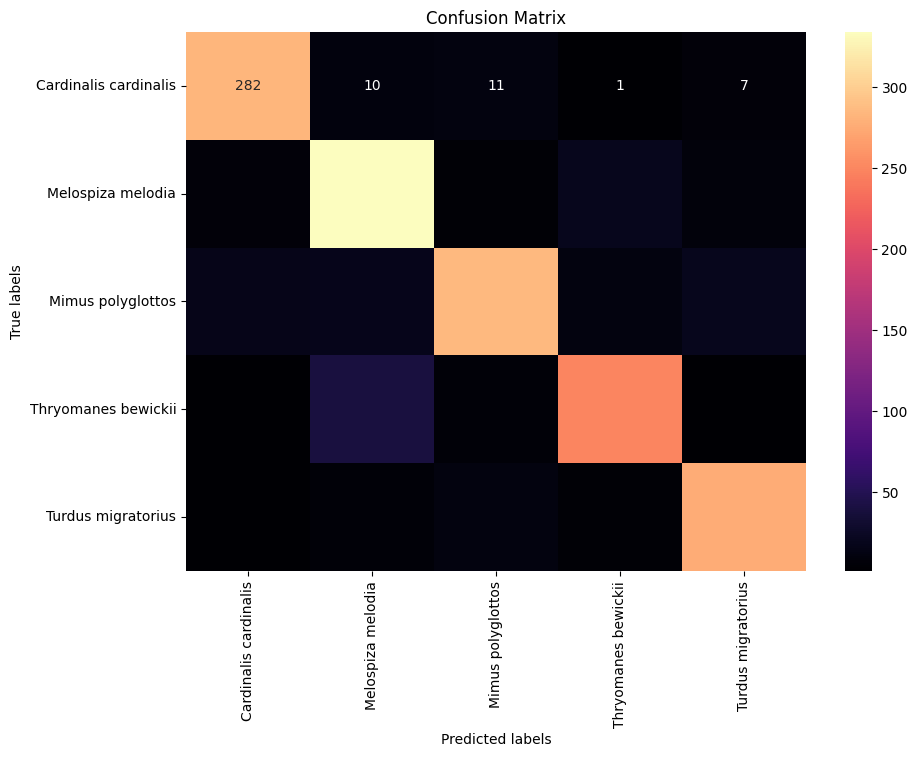

[[282  10  11   1   7]
 [  7 334   4  19   8]
 [ 16  17 285  11  19]
 [  2  40   5 249   2]
 [  1   6  11   4 276]]


In [64]:
cm_mfcc = confusion_matrix(y_test, y_pred)

# Plotting using seaborn 
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='magma', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(cm_mfcc)

In [65]:

def extract_log_mel_spectrogram(audio, sr, n_fft=2048, hop_length=512, n_mels=128):
    # Calculate Mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)  # Convert the Mel spectrogram to logarithmic scale (decibels)
    
    return S_DB  # Return the log Mel spectrogram data directly


# 'bird_sounds' is an array-like structure with audio data and 'sampling_rate' is defined
log_mel_spectrogram = extract_log_mel_spectrogram(bird_sounds[0], sampling_rate)


In [66]:
def extract_waveform_features(audio):
    # Calculate simple features from the waveform
    rms = librosa.feature.rms(y=audio).flatten()  # Root Mean Square (RMS) feature, flattened to 1D array
    zcr = librosa.feature.zero_crossing_rate(y=audio).flatten()  # Zero Crossing Rate (ZCR) feature, flattened to 1D array
    
    # Concatenate all features into a single array
    combined_features = np.concatenate((rms, zcr))
    return combined_features
waveform_features = extract_waveform_features(bird_sounds[0])

In [67]:
log_mel_features_list = []
waveform_features_list = []

for sound in bird_sounds:
    log_mel_features = extract_log_mel_spectrogram(sound, sampling_rate)
    waveform_features = extract_waveform_features(sound)
    
    log_mel_features_list.append(log_mel_features)
    waveform_features_list.append(waveform_features)

log_mel_features_list = np.array(log_mel_features_list)
waveform_features_list = np.array(waveform_features_list)


In [68]:
# flattening each Mel spectrogram before adding to the list
log_mel_features_list = [mel_feature.flatten() for mel_feature in log_mel_features_list]


In [69]:
# train-test split and fit the model
X1_train, X1_test, y1_train, y1_test = train_test_split(log_mel_features_list, y_encoded, test_size=0.3, random_state=42)

In [70]:
# Initialize the RandomForestClassifier
clf_log_Mel = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model
clf_log_Mel.fit(X1_train, y1_train)
#prediction
predictions1 = clf_log_Mel.predict(X1_test)
print(f"Accuracy with Mel features: {accuracy_score(y1_test, predictions1)}")


Accuracy with Mel features: 0.7252612169637369


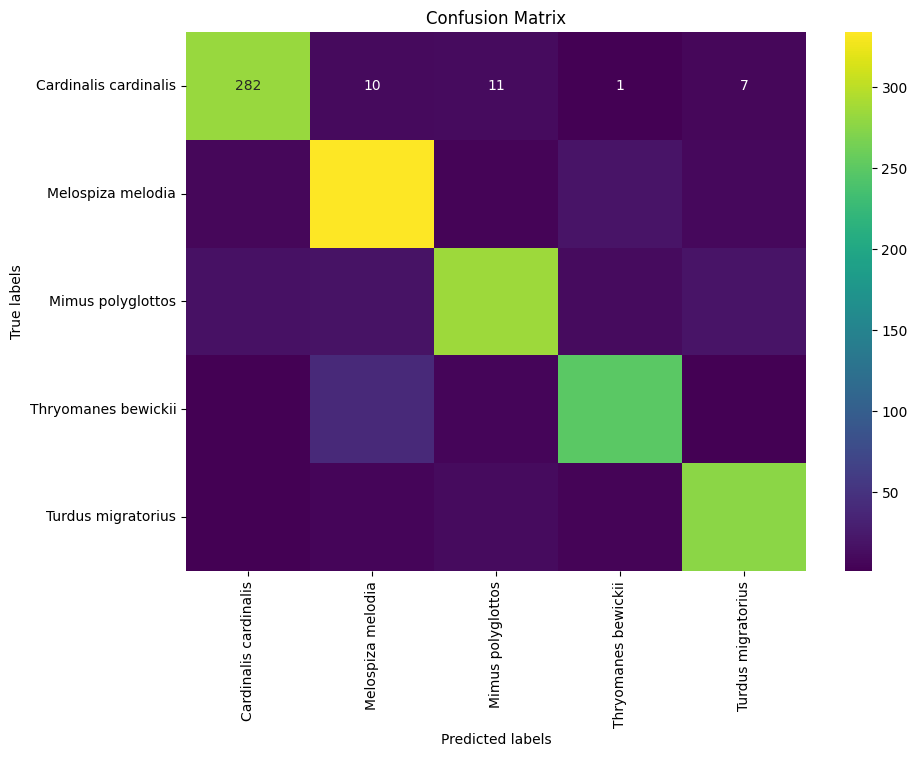

[[238  26  32   3  12]
 [ 20 308   9  28   7]
 [ 51  20 234   7  36]
 [ 15  86   6 191   0]
 [ 21  16  48   4 209]]


In [71]:
cm_Mel = confusion_matrix(y1_test, predictions1)

# Plotting using seaborn 
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(cm_Mel)

In [72]:
# Flatten each element of waveform_features_list
flattened_waveform_features_list = [features.flatten() for features in waveform_features_list]

# Split the dataset into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(flattened_waveform_features_list, y_encoded, test_size=0.3, random_state=42)

# Initialize the RandomForestClassifier
clf_waveform = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf_waveform.fit(X2_train, y2_train)

# Prediction
predictions2 = clf_waveform.predict(X2_test)

# Print the accuracy
print(f"Accuracy with waveform features: {accuracy_score(y2_test, predictions2)}")


Accuracy with waveform features: 0.6699446834665027


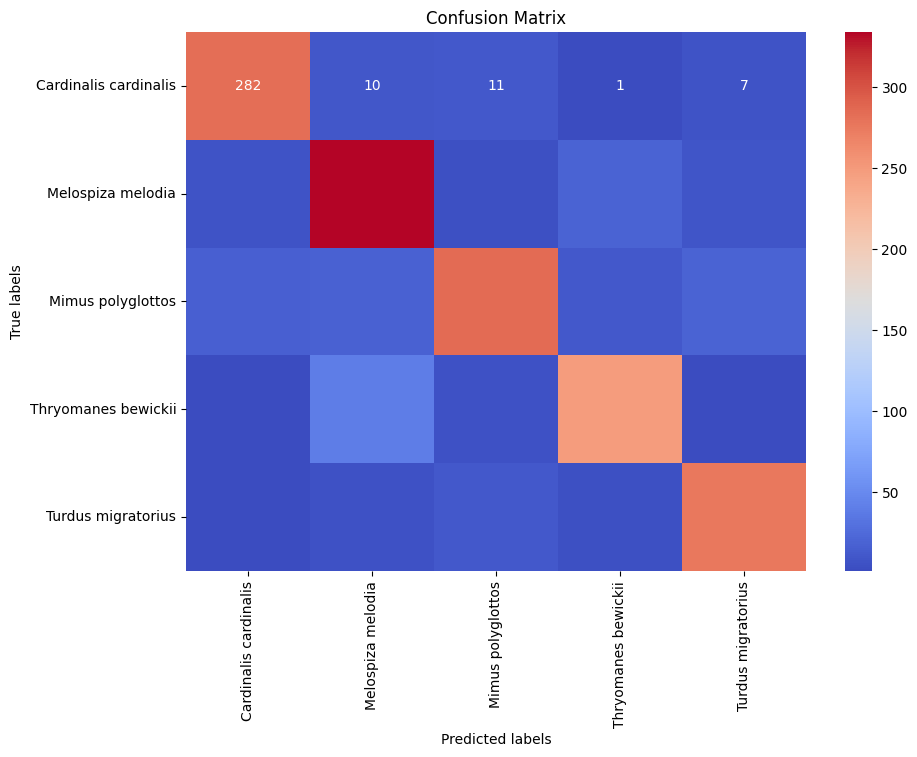

[[206  34  43  10  18]
 [ 21 294  13  40   4]
 [ 51  25 224  19  29]
 [ 14  82  10 186   6]
 [ 39  31  41   7 180]]


In [73]:
cm_waveform = confusion_matrix(y2_test, predictions2)

# Plotting using seaborn 
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(cm_waveform)

In [74]:
all_features = []
for sound in bird_sounds:
    mel_features = extract_log_mel_spectrogram(sound, sampling_rate)
    waveform_features = extract_waveform_features(sound)  # Getting a single array that includes both RMS and ZCR
    
    # Flatten the Mel spectrogram
    mel_features_flattened = mel_features.flatten()
    
    # Combine flattened features
    combined_features = np.concatenate((mel_features_flattened, waveform_features))
    all_features.append(combined_features)

# Convert list of feature arrays to a numpy array
all_features = np.array(all_features)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

# Split dataset
X3_train, X3_test, y3_train, y3_test = train_test_split(all_features, y_encoded, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
clf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
clf_combined.fit(X3_train, y3_train)

# Predict and evaluate
y3_pred = clf_combined.predict(X3_test)
print(f"Accuracy: {accuracy_score(y3_test, y3_pred)}")
print(classification_report(y3_test, y3_pred, target_names=label_encoder.classes_))

Accuracy: 0.7387830362630609
                       precision    recall  f1-score   support

Cardinalis cardinalis       0.72      0.74      0.73       311
    Melospiza melodia       0.68      0.85      0.75       372
    Mimus polyglottos       0.73      0.67      0.70       348
  Thryomanes bewickii       0.80      0.69      0.74       298
   Turdus migratorius       0.80      0.73      0.77       298

             accuracy                           0.74      1627
            macro avg       0.75      0.74      0.74      1627
         weighted avg       0.74      0.74      0.74      1627



Model correctly predicts the outcome 73.88% of the time across all classes.
Of all the instances classified as Cardinalis cardinalis, 72% were correctly classified.
Of all the actual instances of Cardinalis cardinalis, 74% were correctly identified by the model.

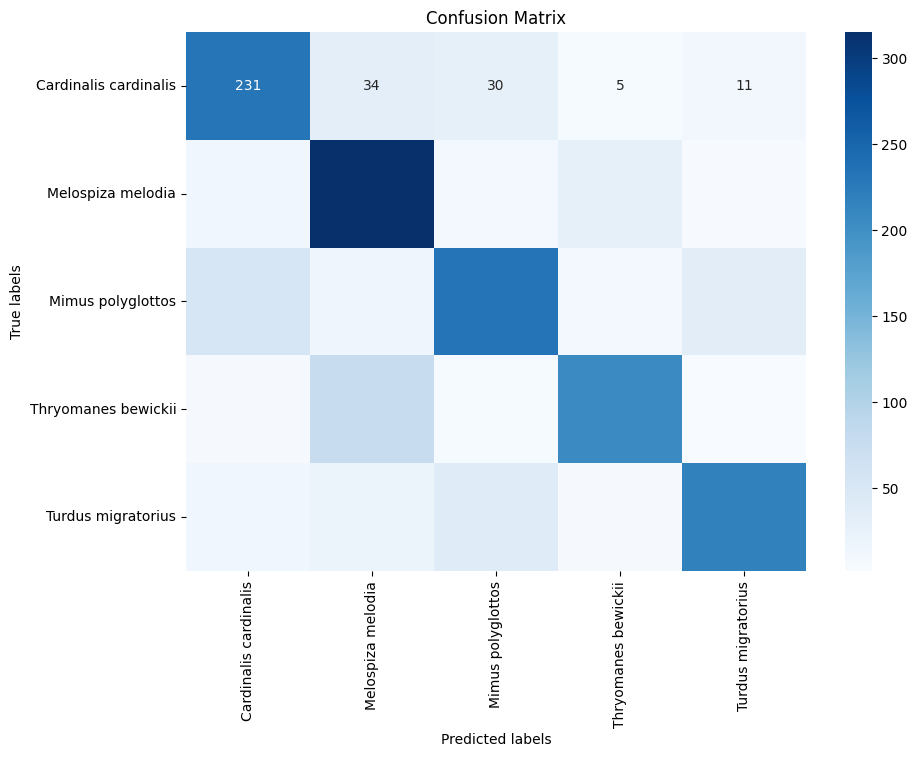

In [75]:
cm = confusion_matrix(y3_test, y3_pred)

# Plotting using seaborn 
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [76]:
print(cm)

[[231  34  30   5  11]
 [ 14 315  10  29   4]
 [ 54  16 232  10  36]
 [  6  79   5 206   2]
 [ 14  20  40   6 218]]


231 instances were correctly predicted as Cardinalis cardinalis, but 34 were incorrectly predicted as Melospiza melodia, 30 as Mimus polyglottos, 5 as Thryomanes bewickii, and 11 as Turdus migratorius.